### Exponential Smoothing with `JAX`

Consider the simple (or single) exponential smoothing model given by
$$
\hat{y}_{t+1} = \alpha y_t + (1 - \alpha)(y_t - \hat{y}_t),
$$
where $\hat{y}_t$ is the predicted value of $y_t$ at time $t$, while $y_t$ denotes the true observed value at time $t$. Thus the prediction for the next timestep is given as a weighted combination of the last observed value and its predicted value. In this notebook, we'll fit the above model to the Kaggle air passengers dataset.

In [1]:
import jax
import jax.numpy as jnp
from jax import random
import pandas as pd
from collections import namedtuple
from plotnine import ggplot, aes, geom_line, scale_x_datetime
randkey = random.PRNGKey(0)
ModelParams = namedtuple('ModelParams', 'alpha')

In [2]:
air_passengers = pd.read_csv("datasets/AirPassengers.csv", parse_dates=['Month'])
training_data = jnp.array(air_passengers['#Passengers'])
air_passengers

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


This dataset is typical of business/economic timeseries data, exhibiting trend and seasonality seen clearly in the chart below.

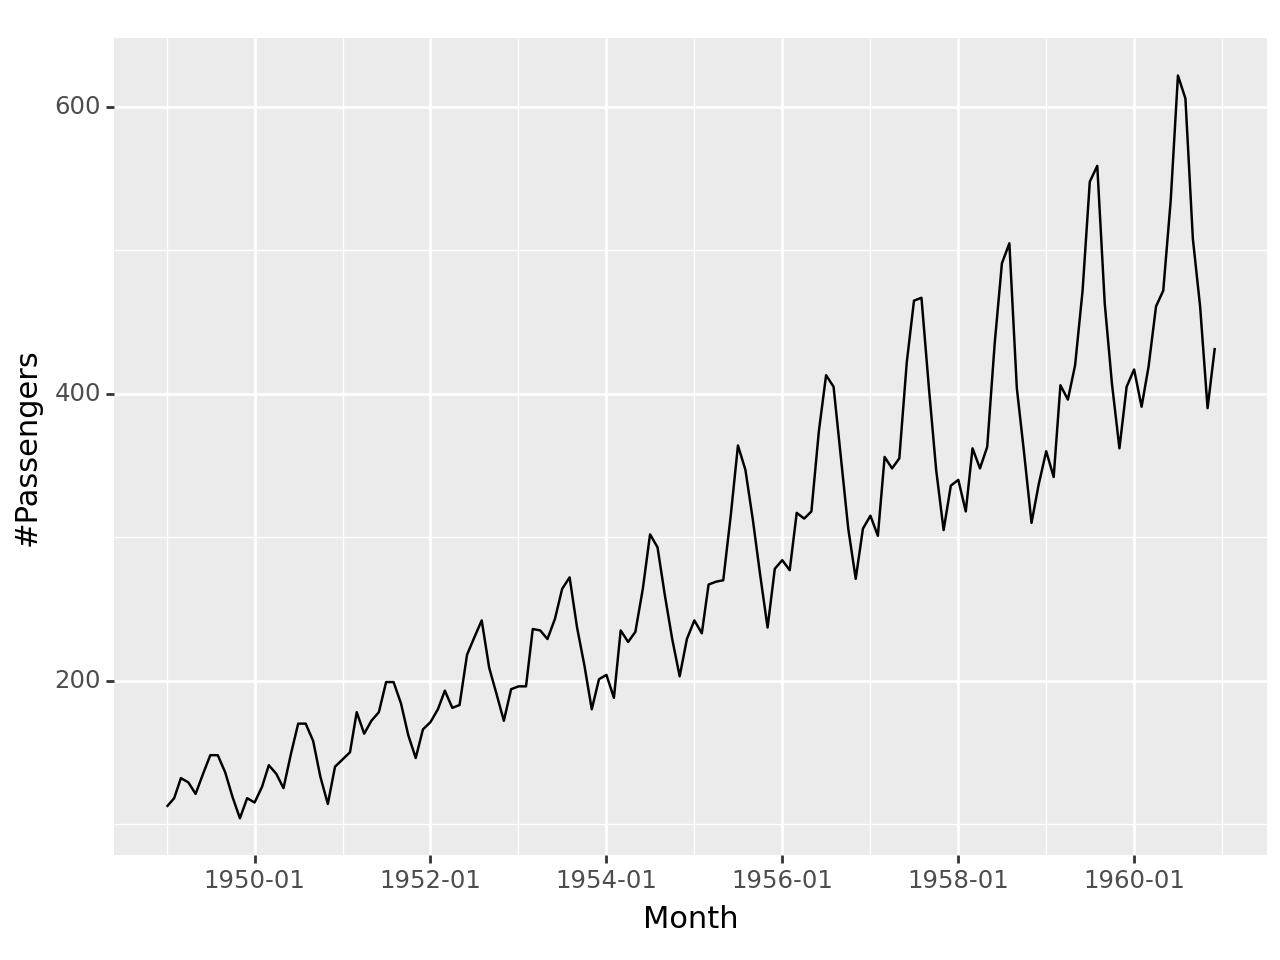

<Figure Size: (640 x 480)>

In [3]:
ggplot(air_passengers) + aes(x="Month", y="#Passengers") + scale_x_datetime(date_labels="%Y-%m")  + geom_line()

Here the model itself is defined, along with a mean-squared error loss function.

In [4]:
@jax.jit
def predict_single(params: ModelParams, y, y_hat):
    return params.alpha * y + (1.0 - params.alpha) * y_hat

@jax.jit
def predict(params: ModelParams, ys: jnp.array):
    predictions = [ys[0]]
    for k in range(0, len(ys)):
        y_hat = predict_single(params, ys[k], predictions[k])
        predictions.append(y_hat)
    return jnp.array(predictions)

@jax.jit
def loss(params: ModelParams, ys: jnp.array):
    preds = predict(params, ys)[:-1]
    return jnp.square(preds - ys).mean()

loss_grad = jax.grad(loss)
params = ModelParams(0.1)

Let's have a look at the uncalibrated model's predictions.

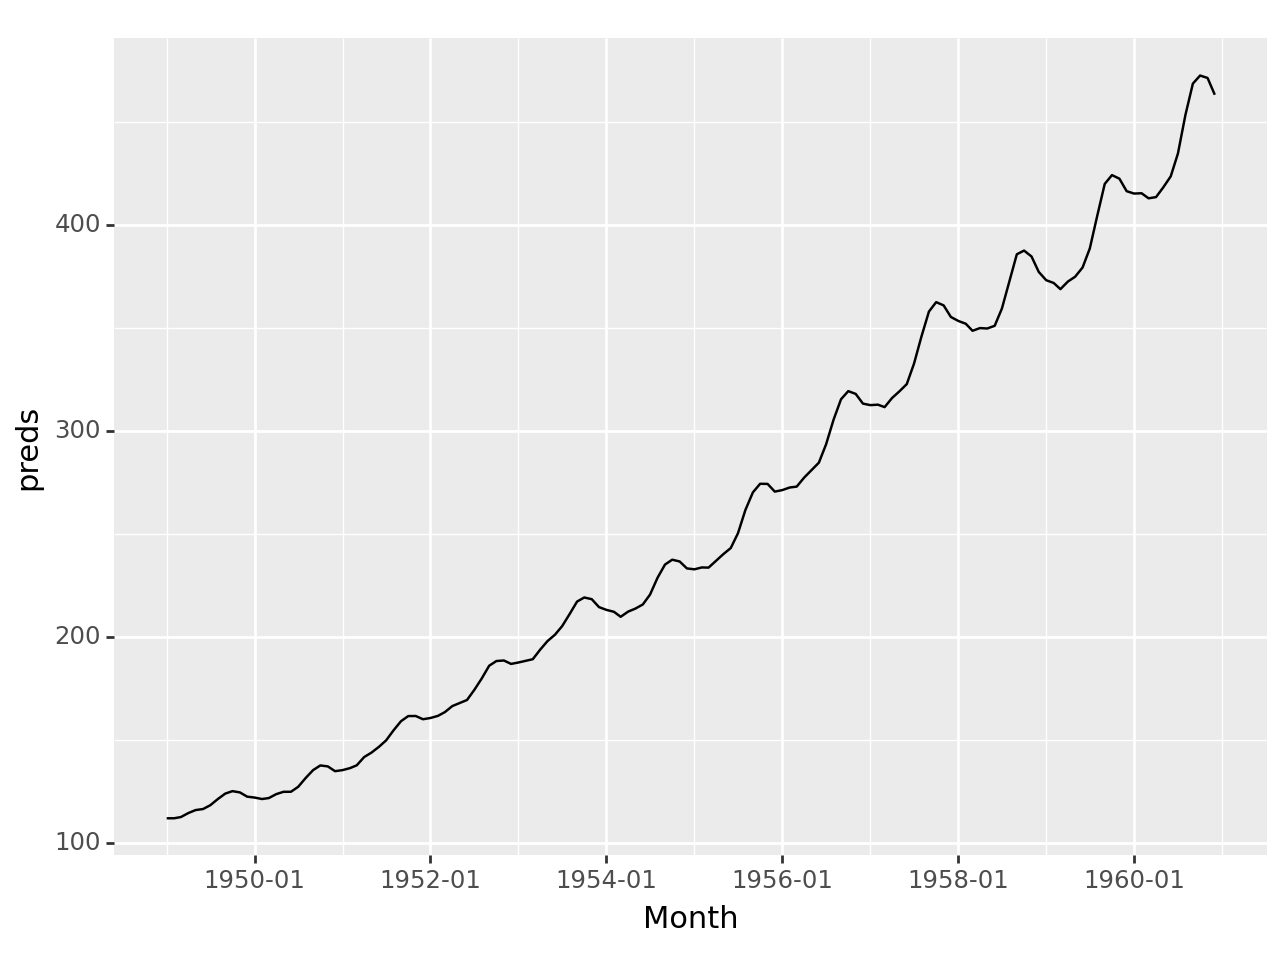

<Figure Size: (640 x 480)>

In [5]:
air_passengers['preds'] = predict(params, training_data)[:-1]
ggplot(air_passengers) + aes(x="Month", y="preds") + scale_x_datetime(date_labels="%Y-%m") + geom_line()  

Training proceeds as usual: minimize loss via gradient descent.

In [6]:
eta = 1e-4
for i in range(10_000):
    if i % 10 == 0:
        ell = loss(params, training_data)
        print(f"loss {ell:.2}")
        print(f"alpha is now {params.alpha:.5}")
    G = loss_grad(params, training_data)
    old_params = params
    params = ModelParams(params.alpha - eta * G.alpha)
    if abs(old_params.alpha - params.alpha) < 1e-6:
        break

loss 2.7e+03
alpha is now 0.1
loss 9.9e+02
alpha is now 1.3739
loss 9.9e+02
alpha is now 1.4016
loss 9.9e+02
alpha is now 1.4058
loss 9.9e+02
alpha is now 1.4065
loss 9.9e+02
alpha is now 1.4066


Let's see how it looks.

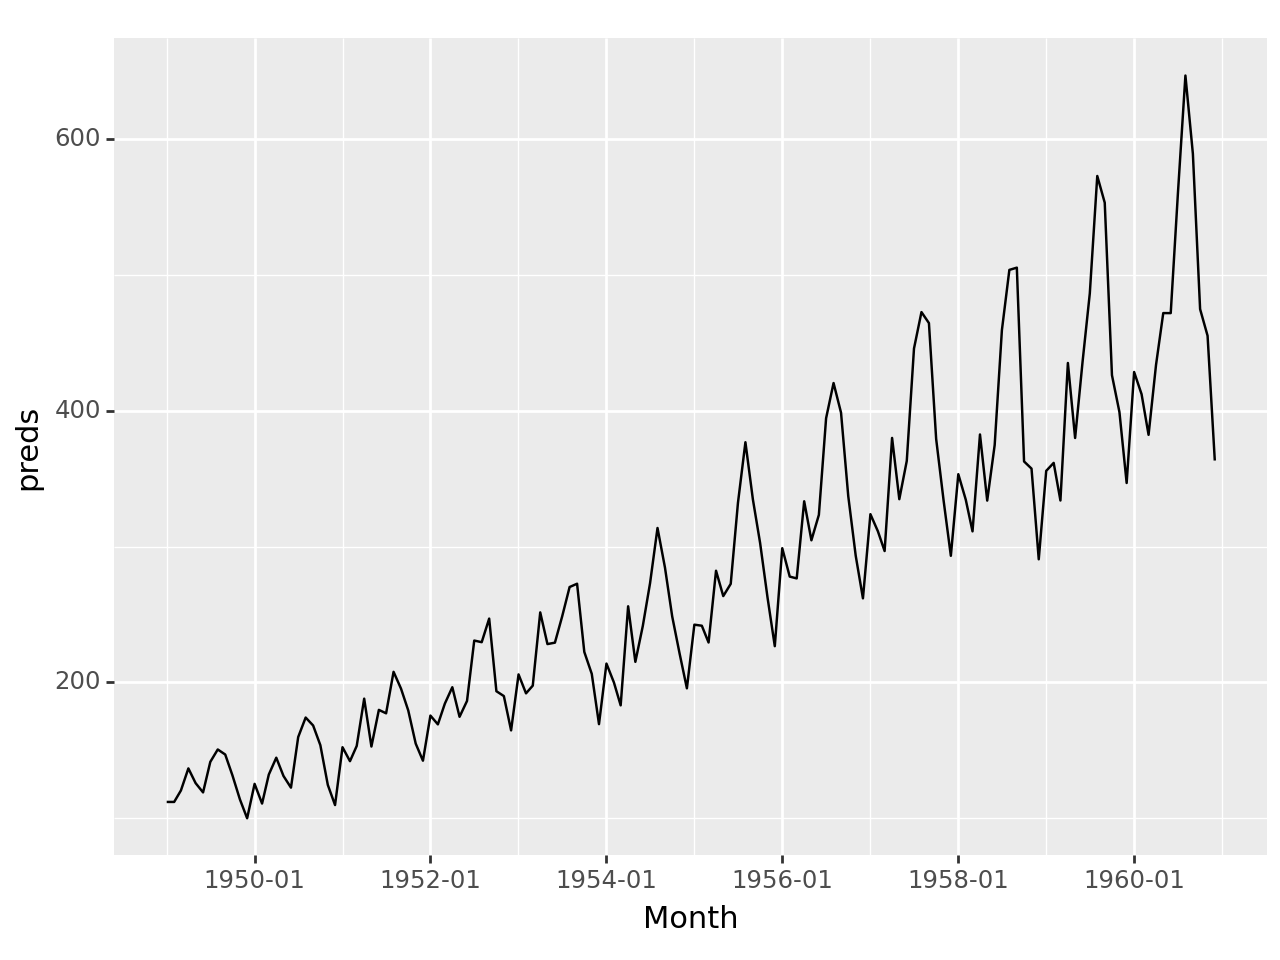

<Figure Size: (640 x 480)>

In [7]:
air_passengers['preds'] = predict(params, training_data)[:-1]
ggplot(air_passengers) + aes(x="Month", y="preds") + scale_x_datetime(date_labels="%Y-%m") + geom_line()

Let's use `statsmodels` and fit a baseline simple exponential smoothing model to this data for comparison.

In [8]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
res = SimpleExpSmoothing(air_passengers['#Passengers']).fit()
res.summary()

Dep. Variable:,#Passengers,No. Observations:,144
Model:,SimpleExpSmoothing,SSE,163003.353
Optimized:,True,AIC,1016.567
Trend:,None,BIC,1022.506
Seasonal:,None,AICC,1016.854
Seasonal Periods:,None,Date:,"Mon, 14 Aug 2023"
Box-Cox:,False,Time:,09:38:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,112.00000,l.0,False


`statsmodels` has chosen a very different $\alpha$ coefficient (here called `smoothing_level`). Is our result bad? We can set the `smoothing_level` to our model's value and see what the scorecard says. Pay attention to the AIC in the results below:

In [9]:
res = SimpleExpSmoothing(air_passengers['#Passengers']).fit(smoothing_level=params.alpha)
res.summary()

/home/sca/kaggle/.venv/lib/python3.10/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning


Dep. Variable:,#Passengers,No. Observations:,144
Model:,SimpleExpSmoothing,SSE,142454.663
Optimized:,False,AIC,997.163
Trend:,None,BIC,1003.103
Seasonal:,None,AICC,997.451
Seasonal Periods:,None,Date:,"Mon, 14 Aug 2023"
Box-Cox:,False,Time:,09:38:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4065973,alpha,False
initial_level,112.00000,l.0,False


Observe that our model actually fits the data marginally better than the one `statsmodels` determined.